# Book Recommendation System

In [59]:
import string
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

# EDA

In [60]:
books = pd.read_csv("Books.csv")
ratings = pd.read_csv("Ratings.csv")
users = pd.read_csv("Users.csv")

In [61]:
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [62]:
books.shape

(271360, 8)

In [63]:
ratings.shape

(1149780, 3)

In [64]:
books.groupby("Book-Title").agg({"ISBN":"count"}).sort_values("ISBN",ascending=False).head(10)

,ISBN
Book-Title,
Selected Poems,27
Little Women,24
Wuthering Heights,21
Dracula,20
Adventures of Huckleberry Finn,20
The Secret Garden,20
Jane Eyre,19
The Night Before Christmas,18
Pride and Prejudice,18


In [65]:
df_ratings_books = books.merge(ratings, how='left', on='ISBN')
df_ratings_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2.0,0.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8.0,5.0
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400.0,0.0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676.0,8.0
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385.0,0.0


In [66]:
df_ratings_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1032345 entries, 0 to 1032344
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   ISBN                 1032345 non-null  object 
 1   Book-Title           1032345 non-null  object 
 2   Book-Author          1032343 non-null  object 
 3   Year-Of-Publication  1032345 non-null  object 
 4   Publisher            1032343 non-null  object 
 5   Image-URL-S          1032345 non-null  object 
 6   Image-URL-M          1032345 non-null  object 
 7   Image-URL-L          1032341 non-null  object 
 8   User-ID              1031136 non-null  float64
 9   Book-Rating          1031136 non-null  float64
dtypes: float64(2), object(8)
memory usage: 78.8+ MB


In [67]:
df_ratings_books.isnull().sum()

ISBN                      0
Book-Title                0
Book-Author               2
Year-Of-Publication       0
Publisher                 2
Image-URL-S               0
Image-URL-M               0
Image-URL-L               4
User-ID                1209
Book-Rating            1209
dtype: int64

In [68]:
check = df_ratings_books.groupby("Book-Title").agg({"Book-Rating":["count","mean"]})
check = check.droplevel(0, axis = 1)
check.head(10)

,count,mean
Book-Title,,
"A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)",4,2.25
Always Have Popsicles,1,0.00
Apple Magic (The Collector's series),1,0.00
"Ask Lily (Young Women of Faith: Lily Series, Book 5)",1,8.00
Beyond IBM: Leadership Marketing and Finance for the 1990s,1,0.00
Clifford Visita El Hospital (Clifford El Gran Perro Colorado),1,0.00
Dark Justice,1,10.00
Deceived,2,0.00
"Earth Prayers From around the World: 365 Prayers, Poems, and Invocations for Honoring the Earth",10,5.00


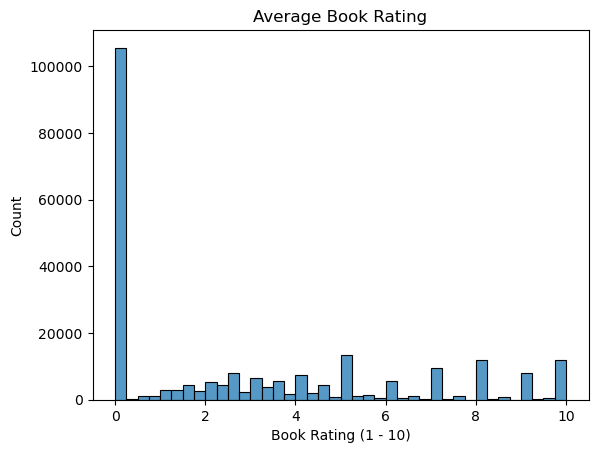

In [69]:
average_book_rating = df_ratings_books.groupby("Book-Title")["Book-Rating"].mean()
sns.histplot(data = average_book_rating, bins = 40)
plt.title("Average Book Rating")
plt.xlabel("Book Rating (1 - 10)")
plt.ylabel("Count")
plt.show()

In [70]:

check.head()
check[check["mean"] < 2].sort_values("count", ascending=False)

,count,mean
Book-Title,,
Wild Animus,2502,1.019584
Slow Waltz in Cedar Bend,248,1.895161
Songs in Ordinary Time (Oprah's Book Club (Paperback)),232,1.857759
Primary Colors: A Novel of Politics,166,1.728916
The Cardinal of the Kremlin (Jack Ryan Novels),166,1.831325
...,...,...
Kates Geheimnis.,1,0.000000
"Kate the Winner! (Sleepover Friends, No 34)",1,0.000000
Kate the Life of Katherine Hepburn (Signet Book),1,0.000000


In [71]:
ratings_per_user = df_ratings_books.groupby("User-ID").count()["Book-Rating"] 
Q1 = ratings_per_user.quantile(0.25)
Q3 = ratings_per_user.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_review_counts = ratings_per_user[(ratings_per_user >= lower_bound) & (ratings_per_user <= upper_bound)]

Text(0.5, 1.0, 'Distribution of Number of Reviews Per User')

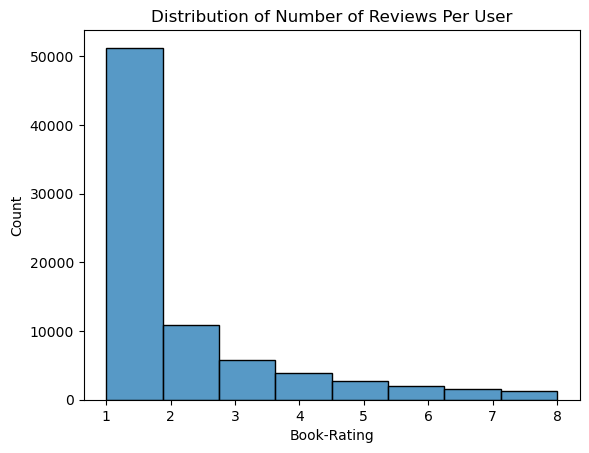

In [72]:
sns.histplot(data = filtered_review_counts, bins = 8)
plt.title("Distribution of Number of Reviews Per User")

We can see the vast majority of people only leave one review, which is not very useful for collaborative filtering or calculating cosine similarity

Text(0.5, 1.0, 'Distribution of Number of Reviews Per User')

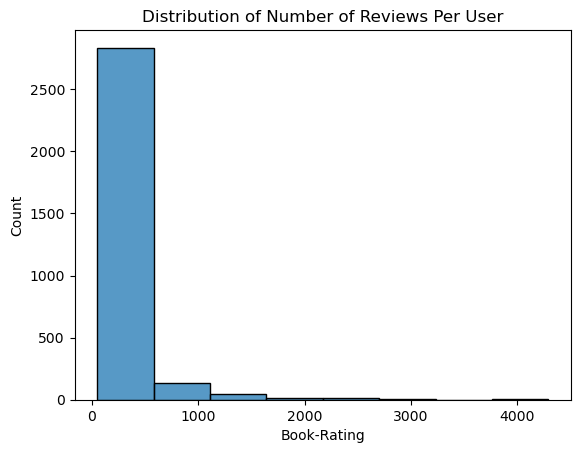

In [73]:
relevant_review_counts = ratings_per_user[(ratings_per_user >= 50) & (ratings_per_user < 5000)]
sns.histplot(data = relevant_review_counts, bins = 8)
plt.title("Distribution of Number of Reviews Per User")

We have to make a decision, a cutoff, a balance between enough total data points and enough reviews to be considered in collaborative filtering.

In [74]:
new = df_ratings_books.groupby("User-ID").count()['Book-Rating'] > 100
user_id_rating_index = new[new].index

In [75]:
filtered_rating = df_ratings_books[df_ratings_books["User-ID"].isin(user_id_rating_index)]

In [76]:
y = filtered_rating.groupby('Book-Title').count()['Book-Rating']>= 50
book_title_rating_index = y[y].index

In [77]:
final_ratings = filtered_rating[filtered_rating['Book-Title'].isin(book_title_rating_index)]
print(final_ratings[['Book-Title','Book-Rating','User-ID']])

                                             Book-Title  Book-Rating   User-ID
31                               The Kitchen God's Wife          9.0   11676.0
32                               The Kitchen God's Wife          9.0   29526.0
33                               The Kitchen God's Wife          0.0   36836.0
34                               The Kitchen God's Wife          9.0   46398.0
38                               The Kitchen God's Wife          0.0  113270.0
...                                                 ...          ...       ...
1029730                                     The Promise          7.0  239594.0
1029943                        The Pillars of the Earth          0.0  240144.0
1029945                             The Handmaid's Tale          0.0  240144.0
1031642                                       Lightning          9.0  244685.0
1032154  The Two Towers (The Lord of the Rings, Part 2)         10.0  259901.0

[97540 rows x 3 columns]


In [78]:
collab_grid = final_ratings.pivot_table(index='Book-Title',columns='User-ID',values='Book-Rating')

In [79]:
collab_grid.fillna(0,inplace=True)

In [81]:
collab_grid.loc['1984']

User-ID
254.0       9.0
507.0       0.0
882.0       0.0
1424.0      0.0
1435.0      0.0
           ... 
277478.0    0.0
277639.0    0.0
278137.0    0.0
278188.0    0.0
278418.0    0.0
Name: 1984, Length: 1634, dtype: float64

In [ ]:
#Using collaborative filtering with cosine similarity
cosine_sim_grid = cosine_similarity(collab_grid)

In [ ]:
cosine_sim_grid.shape

(1070, 1070)

In [ ]:
cosine_sim_grid

array([[1.        , 0.06550754, 0.09317747, ..., 0.07547772, 0.05810769,
        0.03029366],
       [0.06550754, 1.        , 0.02247675, ..., 0.04739871, 0.13548709,
        0.12388301],
       [0.09317747, 0.02247675, 1.        , ..., 0.09310325, 0.        ,
        0.        ],
       ...,
       [0.07547772, 0.04739871, 0.09310325, ..., 1.        , 0.05583662,
        0.0137213 ],
       [0.05810769, 0.13548709, 0.        , ..., 0.05583662, 1.        ,
        0.09410287],
       [0.03029366, 0.12388301, 0.        , ..., 0.0137213 , 0.09410287,
        1.        ]])

In [ ]:
import heapq

def recommend_book(book_name):
    index = np.where(collab_grid.index==book_name)[0][0]
    top_similar_items =  heapq.nlargest(6, enumerate(cosine_sim_grid[index]), key=lambda x: x[1])
    similar_items = top_similar_items[1:]

    item_details = []

    similar_book_indices = [i[0] for i in similar_items]
    # Find the titles of similar books
    similar_books_titles = collab_grid.index[similar_book_indices]
    
    # Filter the books DataFrame for the similar books
    similar_books_df = books[books['Book-Title'].isin(similar_books_titles)]
    # Drop duplicates to ensure each book is represented once
    similar_books_df_unique = similar_books_df.drop_duplicates(subset='Book-Title', keep='first')
    
    # Select required columns
    data = similar_books_df_unique[['Book-Title', 'Book-Author', 'Image-URL-M']].values.tolist()

    return data


In [ ]:
recommend_book('Animal Farm')

[['The Catcher in the Rye',
  'J.D. Salinger',
  'http://images.amazon.com/images/P/0316769487.01.MZZZZZZZ.jpg'],
 ['1984',
  'George Orwell',
  'http://images.amazon.com/images/P/0451524934.01.MZZZZZZZ.jpg'],
 ['Brave New World',
  'Aldous Huxley',
  'http://images.amazon.com/images/P/0060809833.01.MZZZZZZZ.jpg'],
 ['Angus, Thongs and Full-Frontal Snogging: Confessions of Georgia Nicolson',
  'Louise Rennison',
  'http://images.amazon.com/images/P/0064472272.01.MZZZZZZZ.jpg'],
 ['Second Nature',
  'Alice Hoffman',
  'http://images.amazon.com/images/P/0399139087.01.MZZZZZZZ.jpg']]

# Collaborative Filtering w/ Locality Sensitive Hashing

Locality-Sensitive Hashing (LSH) offers several advantages, particularly in the context of handling high-dimensional data and facilitating efficient similarity search, which are critical in applications like recommendation systems, near-duplicate detection, and image or document retrieval. 

One of the primary benefits of LSH is its ability to reduce dimensionality and search space significantly, enabling faster query processing times compared to exhaustive search methods, especially in large datasets. By grouping similar items into the same "buckets" with a high probability, LSH maintains an admirable balance between accuracy and computational efficiency, allowing for near-real-time querying. Furthermore, LSH's flexibility in choosing hash functions and parameters tailored to specific similarity measures (e.g., Jaccard, cosine) enhances its effectiveness across various data types and applications.

This method scales well with data size and dimensionality, making it highly suitable for big data scenarios where traditional methods falter due to the "curse of dimensionality."

Since we used cosine similarity for our initial recommendation system. A random projection based LSH would be more appropriate but if we were instead using a Jaccard based similarity a MinHash system would be more appropriate.

In [ ]:
ex = collab_grid.to_numpy()
ex.shape

(1070, 1634)

In [ ]:
import faiss




Faiss, developed by Facebook AI Research (FAIR), is a comprehensive library for efficient similarity search and clustering of dense vectors. It excels in handling large datasets, allowing for rapid retrieval of items similar to a given query, which is crucial for tasks like recommendation systems, image search, and clustering.

The `IndexLSH` in Faiss is specifically designed for handling high-dimensional data through the use of Locality-Sensitive Hashing (LSH). LSH is a technique that hashes input items in such a way that similar items map to the same "buckets" with high probability. This approach makes searches efficient even in very large datasets by reducing the dimensionality of the data and focusing search efforts on buckets likely to contain similar items.

In [ ]:
d = ex.shape[1]
d

1634

In [ ]:
index = faiss.IndexLSH(d, 4)

In [ ]:
index.is_trained

True

In [ ]:
index.add(ex)

In [ ]:
queries = collab_grid.iloc[0:1].to_numpy()
q = ex[0]
q.reshape((1,-1))
queries.shape

(1, 1634)

In [ ]:
k = 100
D, I = index.search(queries, k)

In [ ]:
I

array([[   0,   14,   38,   42,   79,   93,   99,  110,  116,  132,  144,
         145,  162,  168,  176,  181,  190,  197,  204,  262,  263,  279,
         310,  330,  332,  334,  369,  387,  402,  419,  463,  479,  483,
         484,  493,  504,  505,  509,  519,  531,  535,  596,  604,  607,
         626,  649,  650,  652,  656,  665,  673,  681,  695,  717,  722,
         733,  744,  747,  762,  768,  777,  784,  787,  835,  841,  842,
         859,  863,  867,  895,  898,  931,  938,  940,  948,  949,  969,
         985,  988,  992,  996, 1021, 1029, 1037, 1038, 1057, 1060, 1067,
           4,    6,   16,   22,   23,   26,   27,   29,   32,   36,   43,
          46]], dtype=int64)

In [ ]:
cos_sim = cosine_similarity(ex[I[0]], queries)
cos_sim.mean()

0.05647985076480734

In [ ]:
cos_sim = cosine_similarity(ex, queries)
cos_sim.mean()

0.04235736615241688

In [ ]:
D

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]], dtype=float32)

In [ ]:
for nbits in [2, 4, 6, 8, 10, 12, 14, 16]:
    buckets = 1 << nbits
    print(f"nbits = {nbits}")
    print(f"{ex.shape[0]} / {buckets} = {ex.shape[0]/buckets}")

nbits = 2
1070 / 4 = 267.5
nbits = 4
1070 / 16 = 66.875
nbits = 6
1070 / 64 = 16.71875
nbits = 8
1070 / 256 = 4.1796875
nbits = 10
1070 / 1024 = 1.044921875
nbits = 12
1070 / 4096 = 0.26123046875
nbits = 14
1070 / 16384 = 0.0653076171875
nbits = 16
1070 / 65536 = 0.016326904296875


In [ ]:
#Choosing Good Buckets

for nbits in [2, 4, 8, 16, 24, 32, 48, 64, 128, 256, 512, 768]:
    index = faiss.IndexLSH(d, nbits)
    index.add(ex)
    D, I = index.search(ex[6].reshape((1,-1)), k)
    cos = cosine_similarity(ex[I[0]], queries)
    print(f"nbits = {nbits}")
    print(f"sim: {cos.mean()}")

nbits = 2
sim: 0.036334443628718203
nbits = 4
sim: 0.06285069778358147
nbits = 8
sim: 0.03845606050944478
nbits = 16
sim: 0.03142432326560882
nbits = 24
sim: 0.03771130270095232
nbits = 32
sim: 0.05272186992192931
nbits = 48
sim: 0.03494501523950675
nbits = 64
sim: 0.04589483665944031
nbits = 128
sim: 0.043021838419761274
nbits = 256
sim: 0.03931886801025212
nbits = 512
sim: 0.047161754765130307
nbits = 768
sim: 0.04187253958641512


In [ ]:
buckets

65536

In [ ]:
def recommend_book_lsh(book_name,  n_neighbours: int, nbits=512):
    book_index = np.where(collab_grid.index==book_name)[0][0]
    index = faiss.IndexLSH(ex.shape[1], nbits)
    index.add(ex)
    query = ex[book_index].reshape((1,-1))
    D, I = index.search(query, n_neighbours + 1)

    similar_book_indices = I[0][1:]  # Exclude the first item (itself)
    
    # Find the titles of similar books
    similar_books_titles = collab_grid.index[similar_book_indices]
    
    # Filter the books DataFrame for the similar books
    similar_books_df = books[books['Book-Title'].isin(similar_books_titles)]
    # Drop duplicates to ensure each book is represented once
    similar_books_df_unique = similar_books_df.drop_duplicates(subset='Book-Title', keep='first')
    
    # Select required columns
    data = similar_books_df_unique[['Book-Title', 'Book-Author', 'Image-URL-M']].values.tolist()

    return data
    
    
    



In [ ]:
recommend_book_lsh('1984', 10)

[['A Little Princess',
  'Frances Hodgson  Burnett',
  'http://images.amazon.com/images/P/0874067391.01.MZZZZZZZ.jpg'],
 ['Lightning',
  'Dean R. Koontz',
  'http://images.amazon.com/images/P/0425115801.01.MZZZZZZZ.jpg'],
 ['Love in the Time of Cholera (Penguin Great Books of the 20th Century)',
  'Gabriel Garcia Marquez',
  'http://images.amazon.com/images/P/0140119906.01.MZZZZZZZ.jpg'],
 ['Brave New World',
  'Aldous Huxley',
  'http://images.amazon.com/images/P/0060809833.01.MZZZZZZZ.jpg'],
 ['The Prince of Tides',
  'Pat Conroy',
  'http://images.amazon.com/images/P/0553268880.01.MZZZZZZZ.jpg'],
 ['Blindness (Harvest Book)',
  'Jose Saramago',
  'http://images.amazon.com/images/P/0156007754.01.MZZZZZZZ.jpg'],
 ['The Corrections',
  'Jonathan Franzen',
  'http://images.amazon.com/images/P/0374129983.01.MZZZZZZZ.jpg'],
 ['Cat and Mouse',
  'James Patterson',
  'http://images.amazon.com/images/P/0316693294.01.MZZZZZZZ.jpg'],
 ['Invisible Monsters',
  'Chuck Palahniuk',
  'http://image